In [1]:
library(dplyr)
library(topGO)
library(readxl)
library(magrittr)
#https://datacatz.wordpress.com/2018/01/19/gene-set-enrichment-analysis-with-topgo-part-1/


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: graph

Loading required package: Biobase

Welcome to Bioconduct

In [2]:
#Read in the DESeq data
deseq_results <- read.csv("Annotation-data/sample_DESEq2_results.tsv", sep = "\t")
head(deseq_results, 5)

,swissprot_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Q39131,20.73702,2.405154,0.4615862,5.210629,1.882014e-07,1.228963e-06
2,Q9VT28,21.55222,-2.371291,0.4201792,-5.643524,1.666044e-08,1.298723e-07
3,Q7RXY1,19.80091,-3.785769,0.5021629,-7.538926,4.738563e-14,2.657159e-13
4,Q9SJA2,15.51202,2.588327,0.4689666,5.519215,3.405170e-08,2.519925e-07
5,Q39434,68.70960,-2.005200,0.4140010,-4.843466,1.275937e-06,3.860169e-06


In [3]:
#Set up for GSEA
#background genes/universal set
#all the swissprot ids 
bg_genes <- deseq_results$swissprot_id
length(bg_genes)

[1] 1000

In [4]:
#genes of interest/genes under selection/differentially expressed genes
selected_genes <- deseq_results %>%
                  #adjust for your experement
                  dplyr::filter(padj < 0.001 & abs(log2FoldChange) > 4) %>%
                  dplyr::select(swissprot_id, log2FoldChange, padj) %>%
                  dplyr::arrange(desc(log2FoldChange)) %>%
                  dplyr::select(swissprot_id)
# head(selected_genes, 2)
# tail(selected_genes, 2)
dim(selected_genes)
sel_genes <- selected_genes$swissprot_id

[1] 241   1

In [5]:
#A filter for selected/DEG genes
geneList <- factor(as.integer(bg_genes %in% sel_genes))
names(geneList) <- bg_genes

In [6]:
#create GO tables for MF and BP categories in the formated expected by TopGO
swissprot2GO <- read.csv("Annotation-data/GJZM01.1.blastx_swissprot2GO_clean.tsv", sep  = "\t", header = F, colClasses=c(rep("character",6)))  
colnames(swissprot2GO) <- c("TransciptID", "SwissProtID", "GO_prefix", "GOID", "GO_classification", "GO_term")
#save swissprort to topGO custom format 
#Those ids without GO terms are not included in this list
swissprotTopGO_MF <- swissprot2GO %>% dplyr::filter(GOID != "")  %>% dplyr::filter(GO_classification == "F") %>% mutate(myGO = paste(GO_prefix, GOID, sep = ":")) %>% group_by(SwissProtID) %>% summarise(GO_terms = paste(myGO, collapse = ", ")) 
write.table(swissprotTopGO_MF, "Annotation-data/GJZM01.1.swissprot2GO_MF.tsv", sep = "\t", row.names = F, quote = F, col.names = F)
swissprotTopGO_BP <- swissprot2GO %>% dplyr::filter(GOID != "")  %>% dplyr::filter(GO_classification == "P") %>% mutate(myGO = paste(GO_prefix, GOID, sep = ":")) %>% group_by(SwissProtID) %>% summarise(GO_terms = paste(myGO, collapse = ", ")) 
write.table(swissprotTopGO_BP, "Annotation-data/GJZM01.1.swissprot2GO_BP.tsv", sep = "\t", row.names = F, quote = F, col.names = F)

In [7]:
#Load mapping for GO terms
geneID2GO_MF <- readMappings("Annotation-data/GJZM01.1.swissprot2GO_MF.tsv")

In [8]:
#Setting for TopGO
#create the TopGO data object
#check the parameters in the documentation
GOdata <- new("topGOdata", ontology = "MF", allGenes = geneList, annot = annFUN.gene2GO, gene2GO = geneID2GO_MF)


Building most specific GOs .....

	( 518 GO terms found. )


Build GO DAG topology ..........

	( 856 GO terms and 1101 relations. )


Annotating nodes ...............

	( 673 genes annotated to the GO terms. )



In [9]:
resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")


			 -- Classic Algorithm -- 

		 the algorithm is scoring 334 nontrivial nodes
		 parameters: 
			 test statistic: fisher



In [10]:
allRes <- GenTable(GOdata, classicFisher = resultFisher, ranksOf = "classicFisher", topNodes = 10)
#Please note that some people correct the p-values for multiple testing 
#https://datacatz.wordpress.com/2018/01/19/gene-set-enrichment-analysis-with-topgo-part-1/

In [11]:
allRes
# Annotated: number of genes (in our gene list) that are annotated with the term
# Significant: Number of significantly DE genes annotated with that term (i.e. genes where geneList = 1)
# Expected: Under random chance, number of genes that would be expected to be significantly DE and annotated with that term
# raw.p.value: P-value from Fisher’s Exact Test, testing for association between significance and pathway membership.

,GO.ID,Term,Annotated,Significant,Expected,classicFisher
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,GO:0004089,carbonate dehydratase activity,3,3,0.74,0.015
2,GO:0004499,"N,N-dimethylaniline monooxygenase activi...",3,3,0.74,0.015
3,GO:0016709,"oxidoreductase activity, acting on paire...",6,4,1.47,0.034
4,GO:0046906,tetrapyrrole binding,40,15,9.80,0.042
5,GO:0030145,manganese ion binding,9,5,2.21,0.044
6,GO:0098772,molecular function regulator,12,6,2.94,0.048
7,GO:0003735,structural constituent of ribosome,28,11,6.86,0.056
8,GO:0004312,fatty acid synthase activity,2,2,0.49,0.060
9,GO:0004352,glutamate dehydrogenase (NAD+) activity,2,2,0.49,0.060


Loading required package: Rgraphviz

Loading required package: grid


Attaching package: 'grid'


The following object is masked from 'package:topGO':

    depth



Attaching package: 'Rgraphviz'


The following objects are masked from 'package:IRanges':

    from, to


The following objects are masked from 'package:S4Vectors':

    from, to




$dag
A graphNEL graph with directed edges
Number of Nodes = 20 
Number of Edges = 21 

$complete.dag
[1] "A graph with 20 nodes."


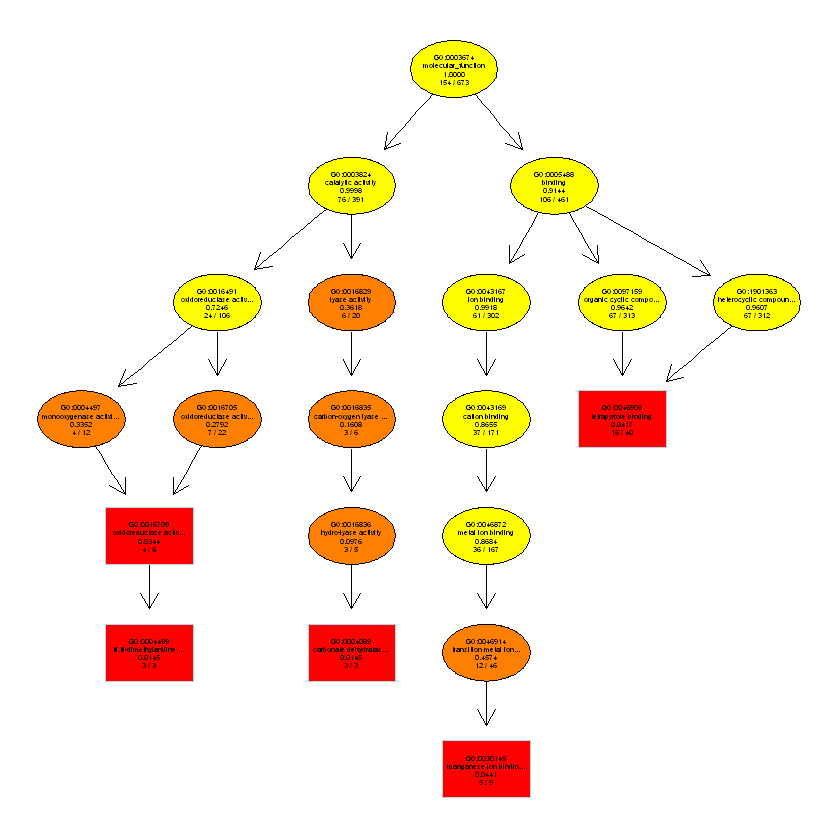

In [12]:
#Lots of visualisation options
#Check the topGO manual
#https://bioconductor.org/packages/release/bioc/vignettes/topGO/inst/doc/topGO.pdf
showSigOfNodes(GOdata, score(resultFisher), firstSigNodes = 5, useInfo = 'all')